# Netflix Autogluon Regression

## Introduction

The data in this notebook is sourced from my family's Netflix account that has been active for over a decade. The goal of this autogluon model will be to predict whether each row (viewing session) was either a 'Movie' or a 'Show' from the 'Type' column under the Netflix profile 'Brette'. Once the data is ready for analysis, it will be passed through the autogluon tabular predictor module creating a regression model. This model will predict the 'Type' category for each viewing session.

### Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

### Loading Data

In [34]:
data = pd.read_csv('Netflix.csv')
data

,Date,Profile Name,Title,Type,Genre,Duration Seconds,Device Type
0,2013-12-29,Sharleen,Jackass: The Movie,Movie,Comedy,23,Apple TV 3 (revised)
1,2013-12-29,Sharleen,Runaway Bride,Movie,Romantic-Comedy,3610,Apple TV 3 (revised)
2,2013-12-29,Sharleen,The Benchwarmers,Movie,Comedy,4696,Apple TV 3 (revised)
3,2013-12-29,Sharleen,This Means War,Movie,Romantic-Comedy,362,Apple TV 3 (revised)
4,2014-01-01,Sharleen,Bloodline,Show,Thriller,1168,Bell Canada Mediaroom Bell Canada Mediaroom
...,...,...,...,...,...,...,...
8447,2024-10-16,Brette,Monsters,Show,Drama-Crime,5468,Netflix Chrome MAC (Cadmium) HTML 5
8448,2024-10-17,Brette,Monsters,Show,Drama-Crime,4974,Netflix Chrome MAC (Cadmium) HTML 5
8449,2024-10-18,Brette,Monsters,Show,Drama-Crime,2038,Netflix Chrome MAC (Cadmium) HTML 5
8450,2024-10-18,Brette,The Menendez Brothers,Movie,Documentary,32,Netflix Chrome MAC (Cadmium) HTML 5


## Cleaning & EDA

To start I will check the dataframe for null values:

In [35]:
data.isnull().sum()

Date                0
Profile Name        0
Title               0
Type                0
Genre               0
Duration Seconds    0
Device Type         0
dtype: int64

Since there are no null values in the data, I will begin creating the final dataframe used for the analysis.

I will now separate out the 'Date' column so that the autogluon tabular model will be able to make better predictions.

In [36]:
data['Date'] = pd.to_datetime(data['Date']) #declaring the 'Date' column as a 'datetime' datatype using pandas

In [37]:
data['Year'] = data['Date'].dt.year #taking the year from the 'Date' column and creating a column of it's own
data['Month'] = data['Date'].dt.month #taking the month from the 'Date' column and creating a column of it's own
data['Day'] = data['Date'].dt.day #taking the day from the 'Date' column and creating a column of it's own

In [38]:
data['Month Name'] = data['Month'].apply(lambda x: calendar.month_name[x][:3]) #Creating a new column with the name of the month displayed for visuals

In [39]:
cols = ['Year','Month', 'Month Name', 'Day'] + [col for col in data.columns if col not in ['Year', 'Month','Month Name','Day']] #telling the df to place the new columns at the beginning of the dataframe 
data = data[cols] 

In [40]:
data = data.drop(columns = 'Date') # dropping the column 'Date' once we have the new columns

Now that the 'Year','Month', 'Month Name', and 'Day' columns are created I will convert the 'Duration_Seconds' columns to minutes for easier analysis

In [41]:
data['Minutes'] = data['Duration Seconds'] / 60 #Dividing by 60 to convert to minutes

In [42]:
data = data.drop(columns='Duration Seconds') #Dropping the 'Duration Seconds' column

##### Changing dtypes for final dataframe

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          8452 non-null   int32  
 1   Month         8452 non-null   int32  
 2   Month Name    8452 non-null   object 
 3   Day           8452 non-null   int32  
 4   Profile Name  8452 non-null   object 
 5   Title         8452 non-null   object 
 6   Type          8452 non-null   object 
 7   Genre         8452 non-null   object 
 8   Device Type   8452 non-null   object 
 9   Minutes       8452 non-null   float64
dtypes: float64(1), int32(3), object(6)
memory usage: 561.4+ KB


For the module to properly read the features I need to convert the text fields to 'category' dtypes

In [44]:
columns_to_convert = [['Month Name','Profile Name','Title','Type','Genre','Device Type']] #specifying the columns to be converted
for cols in columns_to_convert:
    data[cols] = data[cols].astype('category') #changing all the columns listed in columns_to_convert to the dtype 'category'

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Year          8452 non-null   int32   
 1   Month         8452 non-null   int32   
 2   Month Name    8452 non-null   category
 3   Day           8452 non-null   int32   
 4   Profile Name  8452 non-null   category
 5   Title         8452 non-null   category
 6   Type          8452 non-null   category
 7   Genre         8452 non-null   category
 8   Device Type   8452 non-null   category
 9   Minutes       8452 non-null   float64 
dtypes: category(6), float64(1), int32(3)
memory usage: 305.0 KB


For the model to be a regression, I will change the 'Type' column to a binary column, 1 being for the type 'Show', and 0 for 'Movie'

In [46]:
data['type_target'] = np.where(data['Type'] == 'Show', 1, 0) #Creating type_target, where the row says 'Show',1 where it says 'Movie', 0

In [47]:
data = data.drop(columns='Type') #dropping the category 'Type' column

Lastly, to see the rows that contain only the profile name 'Brette' I will filter the dataframe and pass it through to 'data'

In [48]:
data = data[data['Profile Name'] == 'Brette']

### Final DataFrame

#### Now that we have the final dataframe, below are the feature definitions:

- **Year:** The year the show or movie was watched by my Netflix account, **dtype:** int32,
+ **Month:** The month the show or movie was watched by my Netflix account, **dtype:** int32,
- **Month Name:** The name of the month the show or movie was watched by my Netflix account, **dtype:** category,
+ **Day:** The day the show or movie was watched by my Netflix account, **dtype:** int32,
- **Profile Name:** The name of the profile that watched Netflix content, in this dataframe there is only 'Brette', **dtype:** category,
+ **Type:** Whether the content watched was either a 'Show' or 'Movie', **dtype:** category,
- **Genre:** The category that the movie or show is under on Netflix, **dtype:** category,
+ **Device Type:** The device that the movie or show was streamed on while watching, **dtype:** category,
- **Minutes:** The length of time that the show or movie was watched in one sitting period, **dtype:** float64

In [49]:
data

,Year,Month,Month Name,Day,Profile Name,Title,Genre,Device Type,Minutes,type_target
157,2014,3,Mar,10,Brette,Freaks and Geeks,Drama-Comedy,PC,30.766667,1
158,2014,3,Mar,10,Brette,Friday Night Lights,Drama,PC,0.133333,0
160,2014,3,Mar,11,Brette,Freaks and Geeks,Drama-Comedy,PC,39.633333,1
162,2014,3,Mar,13,Brette,American Horror Story,Horror,Apple TV 3 (revised),90.516667,1
165,2014,3,Mar,14,Brette,American Horror Story,Horror,Apple TV 3 (revised),206.400000,1
...,...,...,...,...,...,...,...,...,...,...
8444,2024,10,Oct,15,Brette,Monsters,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,183.916667,1
8447,2024,10,Oct,16,Brette,Monsters,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,91.133333,1
8448,2024,10,Oct,17,Brette,Monsters,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,82.900000,1
8449,2024,10,Oct,18,Brette,Monsters,Drama-Crime,Netflix Chrome MAC (Cadmium) HTML 5,33.966667,1


## Visuals

Below are some visuals to gain more insight on the data:

In [50]:
# Summarize the data
data_summed_genre = data.groupby('Genre', observed=True)['Minutes'].sum().reset_index() #Grouping the genres by the total minutes watched
data_summed_devices = data.groupby('Device Type', observed=True)['Minutes'].sum().reset_index() #Grouping the devices used by total minutes watched
data_summed_years = data.groupby('Year', observed=True)['Minutes'].sum().reset_index() #Grouping each year by the total minutes watched
data_summed_months = data.groupby('Month Name',observed=True)['Minutes'].sum().reset_index() #Grouping each month name by the total minutes watched
top_3_devices = data_summed_devices.nlargest(3, 'Minutes') #Taking the group by above and filtering it to show the top 3

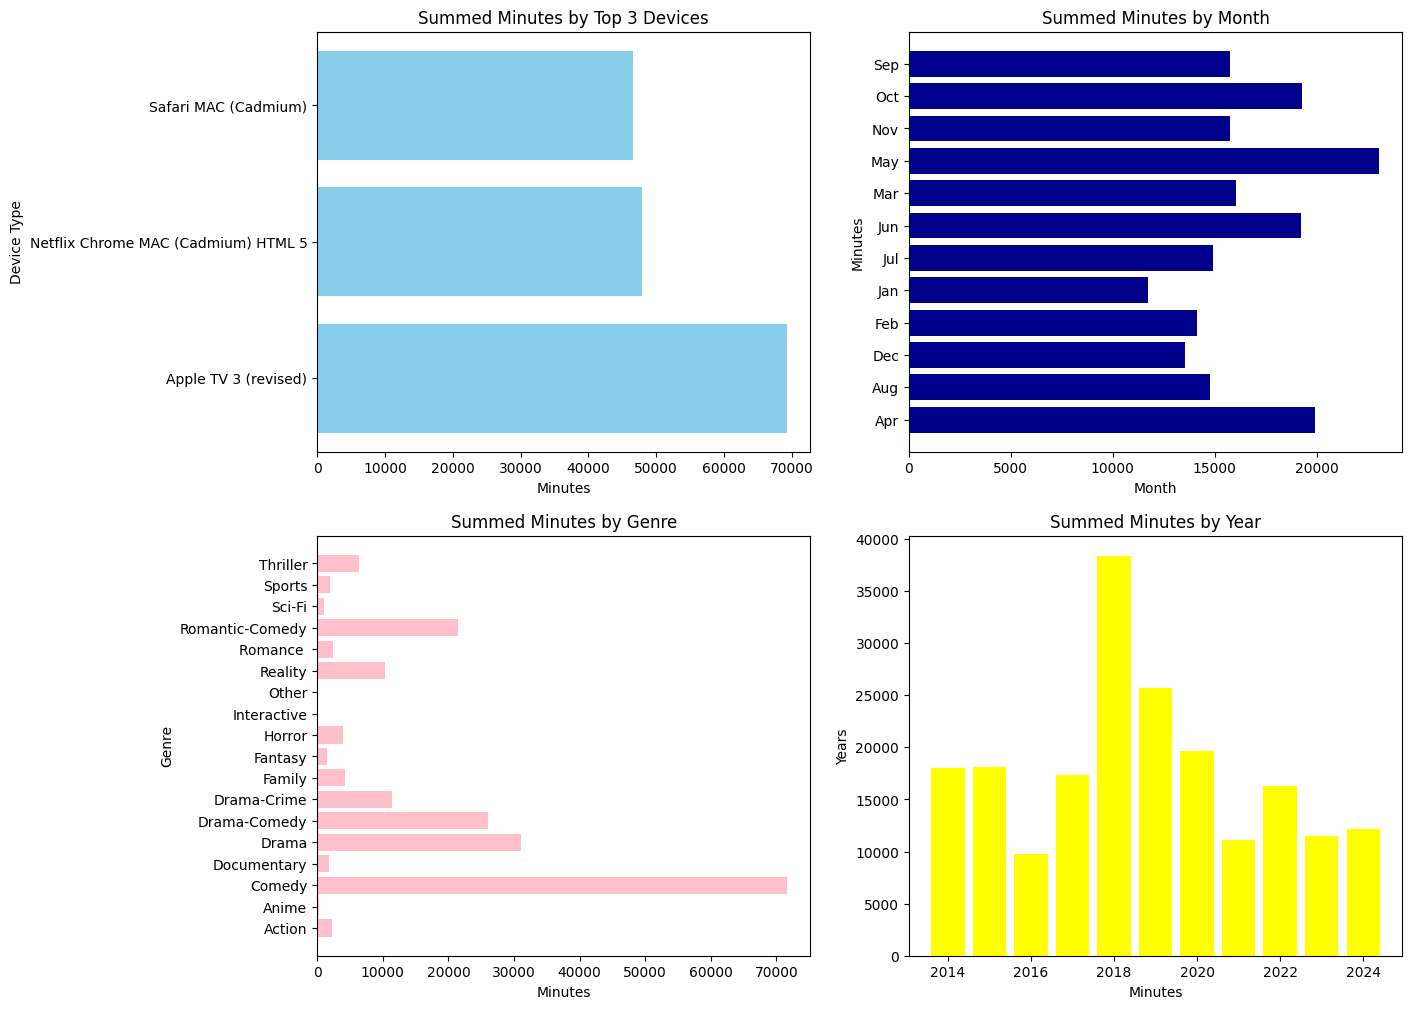

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12)) 

# Plot for the summed minutes by the top 3 devices used by 'Brettes' profile
axes[0, 0].barh(top_3_devices['Device Type'], top_3_devices['Minutes'], color='skyblue') 
axes[0, 0].set_title('Summed Minutes by Top 3 Devices')
axes[0, 0].set_xlabel('Minutes')
axes[0, 0].set_ylabel('Device Type')

# Plot for the summed minutes by each genre
axes[1, 0].barh(data_summed_genre['Genre'], data_summed_genre['Minutes'], color='pink')
axes[1, 0].set_title('Summed Minutes by Genre')
axes[1, 0].set_xlabel('Minutes')
axes[1, 0].set_ylabel('Genre')

# Plot for the summed minutes by each month name
axes[0, 1].barh(data_summed_months['Month Name'], data_summed_months['Minutes'], color='darkblue')
axes[0, 1].set_title('Summed Minutes by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Minutes')

# Plot for the summed minutes by each year
axes[1, 1].bar(data_summed_years['Year'], data_summed_years['Minutes'], color='yellow')
axes[1, 1].set_title('Summed Minutes by Year')
axes[1, 1].set_xlabel('Minutes')
axes[1, 1].set_ylabel('Years')

plt.show();

Now we can begin the analysis.

## Analysis

##### To begin I will import the necessary libraries to perform the autogluon module:

In [68]:
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

##### 'Type' Target Values

Below are the current number of values that belong to both 'Shows' (1) and 'Movies (0)

In [53]:
data['type_target'].value_counts()

type_target
1    2107
0    1228
Name: count, dtype: int64

#### Creating the Train Test Split

Next, I will create a train test split for the autotabular predictor to read from:

In [67]:
#passing the train test split to both train_df which will be passed through the TabularPredictor, and test_df which we will compare the results to
train_df, test_df = train_test_split(data, test_size=0.3, random_state=None, stratify=data['type_target'])

#### Setting the Predictor

Below I am creating the tabular predictor to fit the training data to, the label is the target value, problem_type = 'regression is specifying the type of prediction the autotabular module will make, and the path is where the model pipeline will be stored for future use.

In [55]:
predictor = TabularPredictor(label='type_target', problem_type='regression',path='netflix_regression')

#### Fitting Model

Using the 'predictor' model variable I created above, I will now fit the training data for the autotabular analysis:

In [56]:
predictor.fit(train_df)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.46 GB / 15.68 GB (15.7%)
Disk Space Avail:   656.03 GB / 927.56 GB (70.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accu

[1000]	valid_set's rmse: 0.211131
[2000]	valid_set's rmse: 0.207714


	-0.2075	 = Validation score   (-root_mean_squared_error)
	28.47s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM ...
	-0.195	 = Validation score   (-root_mean_squared_error)
	7.0s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2295	 = Validation score   (-root_mean_squared_error)
	2.11s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1279	 = Validation score   (-root_mean_squared_error)
	62.94s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2262	 = Validation score   (-root_mean_squared_error)
	1.73s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1365	 = Validation score   (-root_mean_squared_error)
	10.35s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1893	 = Validation score   (-root_mean_squared_error)
	2.22s	 = Training   runtime
	0.02s	 = Validation runtime
F

### Summary of Autotabular Model Results

Once the model is fitted, I can now use the model variable to create a summary of the results. You can see below that the highest score was WeightedEnsemble with a score of 12.77 for the root mean squared error, followed by CatBoost with a root mean error squared score of 12.79 since it produced the least amount of errors while making predictions for the data.

In [57]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.127772  root_mean_squared_error       0.062987   69.981583                0.000000           0.046019            2       True         12
1              CatBoost  -0.127941  root_mean_squared_error       0.016482   62.937331                0.016482          62.937331            1       True          6
2       NeuralNetFastAI  -0.136451  root_mean_squared_error       0.048168   10.352901                0.048168          10.352901            1       True          8
3               XGBoost  -0.189307  root_mean_squared_error       0.019917    2.217342                0.019917           2.217342            1       True          9
4              LightGBM  -0.195034  root_mean_squared_error       0.046505    6.998234                0.046505   

C:\Users\coste\miniconda3\envs\tabular\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
C:\Users\coste\miniconda3\envs\tabular\Lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -0.5061506069694024,
  'KNeighborsDist': -0.5041658929802826,
  'LightGBMXT': -0.207526775770575,
  'LightGBM': -0.19503411544882615,
  'RandomForestMSE': -0.22947814410674344,
  'CatBoost': -0.12794137169051573,
  'ExtraTreesMSE': -0.22615873977697382,
  'NeuralNetFastAI': -0.13645134814742146,
  'XGBoost': -0.18930691057148605,
  'NeuralNetTorch': -0.22190848612153094,
  'LightGBMLarge': -0.22629648781017192,
  'WeightedEnsemble_L2': -0.1277718936044195},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighbor

### Metrics

To see all of the metrics for the model, I will now create two separate variables and compare them to one another using autotabular's evaluation feature to see how well the model did compared to the true test results of the original data.

In [69]:
y_test = test_df['type_target'] #passing the test_df created in the train test split above to y_test

In [70]:
test_data = test_df.drop(columns='type_target') #creating 'X' from test_df to compare to the target value and passing it to the variable test_data

In [64]:
y_pred = predictor.predict(test_data) #Passing the predictions from the test_data to y_pred

In [65]:
metrics = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True) #passing y_test to y_true, and y_pred to y_pred to compare the true dataset results to the model's predictions 
#auxiliary_metrics=True to get more metrics other than 'RMSE'
metrics

absolute_metrics = {key: abs(value) for key, value in metrics.items()} #creating an absolute metrics evaluation from the metrics above to replace negative values with positive values for the actual scores
absolute_metrics

{'root_mean_squared_error': 0.11980863156451285,
 'mean_squared_error': 0.014354108197361184,
 'mean_absolute_error': 0.03452726678488279,
 'r2': 0.9383261799812317,
 'pearsonr': 0.9687473117214702,
 'median_absolute_error': 0.005208015441894531}

#### Features Importance

Below are the features contained in the dataframe, these are listed from the features that were least to most important in regards to the creation of the autotabular regression model

In [66]:
importance = predictor.feature_importance(test_df)
importance

These features in provided data are not utilized by the predictor and will be ignored: ['Profile Name']
Computing feature importance via permutation shuffling for 8 features using 1001 rows with 5 shuffle sets...
	7.32s	= Expected runtime (1.46s per shuffle set)
	0.98s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Title,0.493695,0.011969,4.142370e-08,5,0.518340,0.469051
Genre,0.065725,0.004176,1.945199e-06,5,0.074323,0.057126
Year,0.003566,0.000473,3.631882e-05,5,0.004540,0.002592
Month Name,0.002679,0.001008,2.012789e-03,5,0.004756,0.000603
Device Type,0.002429,0.000629,4.949867e-04,5,0.003724,0.001133
Minutes,0.001790,0.000473,5.349762e-04,5,0.002765,0.000816
Month,0.000885,0.000203,3.127023e-04,5,0.001304,0.000466
Day,0.000767,0.000378,5.247604e-03,5,0.001545,-0.000011


## Summary

In conclusion, the autotabular model did not perform well with a low R2 score of 9.3%, however the RMSE score was lower at 11.9% compared to the original value in the autotabular model which is considered better. Given that there is not a lot of correlation in the data a model with a lower accuracy was expected.